# Intrinisc alignments power spectra using the halo model
This example showcases how to use the halo model for intrinsic alignment within CCL to compute GI and II contributions to the shear-shear power spectrum.

In [1]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
import functools

# Preliminaries
First we generate the cosmology, the wavenumber $k$ and scale factor $a$ arrays. The arrays are used for computing the power spectrum, $P(k,a)$.

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

k_arr = np.geomspace(1E-3, 1e3, 128)  # For evaluating
a_arr = np.linspace(0.1, 1, 16)
k_arr_over_h = k_arr / cosmo['h']  # For plotting

We also need to initialize halo model quantities. These are:
 - A halo mass definition.
 - A concentration-mass relation.
 - A halo mass function.
 - A halo bias function.
 - A halo model calculator object that will take care of the various integrals.

In [3]:
# Here we use a mass definition with Delta = 200 times the matter density,
hmd_200m = ccl.halos.MassDef200m()

# the Duffy 2008 concentration-mass relation,
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# the Tinker 2008 halo mass function,
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# the Tinker 2010 halo bias,
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# and the halo model calculator object.
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m, nlog10M=64)

For this halo model, which is based on Fortuna et al. (2021, [https://arxiv.org/abs/2003.02700](https://arxiv.org/abs/2003.02700)), we will need a halo mass profile (taken to be an NFW) and a satellite intrinsic ellipticity/shear profile $\gamma^I(\mathbf{r}, M)$. Power spectra can then be computed by taking the Fourier transform of these profiles. To do this in CCL, we generate a satellite shear HOD:

In [4]:
sat_gamma_HOD = ccl.halos.SatelliteShearHOD(cM, a1h=0.001, b=-2)

# Satellite intrinsic shear profile
The real part of the satellite intrinsic shear profile is determined by $\bar{\gamma}$ which is taken to be
$$
\bar{\gamma}(r)= \begin{cases}a_{1 h}\left(\frac{0.06}{r_{\mathrm{vir}}}\right)^{b}, & \text { if } r<0.06 \mathrm{Mpc} / h \\ a_{1 h}\left(\frac{r}{r_{\mathrm{vir}}}\right)^{b}, & \text { if } r>0.06 \mathrm{Mpc} / h,\end{cases}
$$
while also imposing that $\bar{\gamma}(r)\leq0.3$. The parameters ```a1h``` and ```b``` are inputs to the satellite shear HOD above, together with a concentration-mass relation. For a constant mean intrinsic shear $\bar{\gamma}$, one can set ```b=0``` and the ```a1h``` parameter will determine $\bar{\gamma}$.

To obtain the Fourier transform of the profile, $\hat{\gamma}_s^I(\mathbf{k}, M)$, the FFTLog method will be used by default. Other methods are available but slower. The FFTLog parameters have been set internally to produce fast and accurate results, but can be further tweaked with the ```sat_gamma_HOD_FFTLog.update_precision_fftlog``` function. The real-space and Fourier-space intrinsic shear profiles at redshift 0 for a halo with $M_h=10^{14}$ M$_\odot$ look like this:

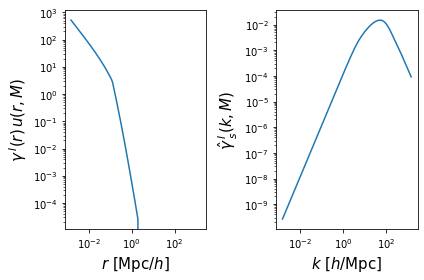

In [5]:
Mhalo = 1e14 # Msun.
a_eval = 1. # Redshift 0.

gamma_r = sat_gamma_HOD._real(cosmo, k_arr, Mhalo, a_eval, hmd_200m)
gamma_k = sat_gamma_HOD._usat_fourier(cosmo, k_arr, Mhalo, a_eval, hmd_200m)

fig, ax = plt.subplots(1, 2)
ax[0].plot(k_arr_over_h, gamma_r)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\gamma\,^I(r)\,u(r,M)\,$', fontsize=15)
ax[0].set_xlabel(r'$r\,\,[{\rm Mpc}/h]$', fontsize=15)

ax[1].plot(k_arr_over_h, -gamma_k)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$\hat{\gamma}\,_s^I(k, M)\,\,$', fontsize=15)
ax[1].set_xlabel(r'$k\,\,[h/{\rm Mpc}]$', fontsize=15)
fig.tight_layout()
plt.show()

# Defining the two-point function
Following Eqs (17)-(18) in Fortuna et al. (2021), the 1-halo power spectra for the satellite GI and II contribution can be computed via
$$
P_{\delta \mathrm{I}, 1 \mathrm{h}}^{s}(\mathbf{k}, z)=\int \mathrm{d} M n(M) \frac{M}{\bar{\rho}_{m}} f_{s}(z) \frac{\left\langle N_{s} \mid M\right\rangle}{\bar{n}_{s}(z)}\left|\hat{\gamma}_{s}^{I}(\mathbf{k} \mid M)\right| u(k, M)
$$
and
$$
P_{\mathrm{II}, 1 \mathrm{h}}^{s s}(\mathbf{k}, z)=\int \mathrm{d} M n(M) f_{s}^{2}(z) \frac{\left\langle N_{s}\left(N_{s}-1\right) \mid M\right\rangle}{\bar{n}_{s}^{2}(z)}\left|\hat{\gamma}_{s}^{I}(\mathbf{k} \mid M)\right|^{2}.
$$
This will help us create the two-point function of the two profiles that are being correlated, $\langle v_1 v_2 \rangle$, with $v_2$ being the satellite intrinsic shear and $v_1$ the NFW profile or the satellite intrinsic shear for the $\delta \mathrm{I}$ and $\mathrm{II}$ power spectra respectively. Before we can do this, however, we need to determine $f_s(z)$, the satellite fraction for our galaxy sample. This can be done self-consistently within the HOD by calculating the number densities of central and satellite galaxies,
$$
n_c(z) = \int_{M_\mathrm{min}}^{M_\mathrm{max}} \frac{\langle N_c|M\rangle}{M} \frac{\mathrm{d}n}{\mathrm{d}\log M} \mathrm{d} M.
$$
and
$$
n_s(z) = \int_{M_\mathrm{min}}^{M_\mathrm{max}} \frac{\langle N_c|M\rangle\langle N_s|M\rangle}{M} \frac{\mathrm{d}n}{\mathrm{d}\log M} \mathrm{d} M.
$$
The $\bar{\rho}_M$ will be taken from the matter profile, which is assumed to be NFW and, if satellites are assumed to have a Poisson distribution, it can be shown that $\langle N_s(Ns-1)|M\rangle=\langle N_s|M\rangle^2$ (Zheng 2004: ArXiV:0408564).

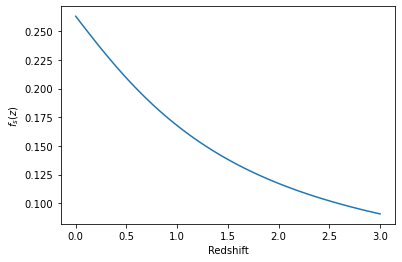

In [6]:
def number_densities(a, prof: ccl.halos.HaloProfileHOD, M_use: np.ndarray):
    nc = simps(prof._Nc(M_use, a) * nM.get_mass_function(cosmo, a=a, M=M_use) / M_use,
               M_use)
    ns = simps(prof._Nc(M_use, a) * prof._Ns(M_use, a) * nM.get_mass_function(cosmo, a=a, M=M_use) / M_use,
               M_use)
    return nc, ns

def satellite_fraction(a, prof: ccl.halos.HaloProfileHOD, M_use: np.ndarray):
    nc, ns = number_densities(a, prof, M_use)
    if nc+ns<10**(-30):
        return 0.
    else:
        return ns/(nc+ns)

z_arr = np.linspace(0, 3, 100)
plt.plot(z_arr, [satellite_fraction(a, sat_gamma_HOD, hmc._mass) for a in 1/(1+z_arr)])
plt.xlabel('Redshift')
plt.ylabel('$f_s(z)$')
plt.show()

In [7]:
# The two-point function for the GI and II power spectra.
# In the GI case, the prof is assumed to be an NFW while prof2 is the satellite shear HOD.

class Profile2pt_GI(ccl.halos.Profile2pt):
    def fourier_2pt(self, prof: ccl.halos.HaloProfileHOD, cosmo, k, M, a,
                    prof2: ccl.halos.HaloProfileHOD, mass_def=None):
        Ns_M_mean = prof2._Ns(M, a).reshape(len(M), 1)
        Nc_mean, Ns_mean = number_densities(a, prof2, hmc._mass)
        if Ns_mean+Nc_mean==0:
            fs = 0.
        else:
            fs = Ns_mean/(Nc_mean+Ns_mean)
        # average matter density.
        rhom_HM = hmc.profile_norm(cosmo, a, prof)**(-1)
        return fs * Ns_M_mean * prof._fourier(cosmo, k, M, a, mass_def) * \
                prof2._usat_fourier(cosmo, k, M, a, mass_def)/(Ns_mean * rhom_HM)

class Profile2pt_II(ccl.halos.Profile2pt):
    def fourier_2pt(self, prof: ccl.halos.HaloProfileHOD, cosmo, k, M, a,
                    prof2=None, mass_def=None):
        Ns_M_mean = prof._Ns(M, a).reshape(len(M), 1)
        Nc_mean, Ns_mean = number_densities(a, prof, hmc._mass)
        if Ns_mean+Nc_mean==0:
            fs = 0.
        else:
            fs = Ns_mean/(Nc_mean+Ns_mean)
        return fs ** 2. * Ns_M_mean ** 2. * prof._usat_fourier(cosmo, k, M, a, mass_def) ** 2. / Ns_mean ** 2.

HOD2pt_II = Profile2pt_II()
HOD2pt_GI = Profile2pt_GI()

# Power spectra
We now have all we need to compute the 1-halo satellite power spectra for the GI and II contributions. We can use the ```ccl.halos.Halomod_Pk2D``` class to sample these across the scale factor and wavenumber ranges we defined earlier.

In [8]:
# NFW profile for matter (G)
NFW =  ccl.halos.HaloProfileNFW(cM, truncated=True, fourier_analytic=True)

pk_GI_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, NFW,
                                  prof_2pt=HOD2pt_GI,
                                  prof2 = sat_gamma_HOD,
                                  get_2h = False,
                                  lk_arr = np.log(k_arr),
                                  a_arr = a_arr)
pk_II_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD,
                                  prof_2pt=HOD2pt_II,
                                  get_2h = False,
                                  lk_arr = np.log(k_arr),
                                  a_arr = a_arr)

Let's also compute the NLA power spectra for comparison.

In [9]:
A_NLA=1
C1 = 5e-14/cosmo['h']**2
C1tilde = A_NLA * C1 * cosmo['Omega_m'] * ccl.physical_constants.RHO_CRITICAL * cosmo['h']**2 / ccl.background.growth_factor(cosmo, 1)
pk_II_NLA = C1tilde**2 * ccl.nonlin_matter_power(cosmo, k_arr, 1)
pk_GI_NLA = -C1tilde * ccl.nonlin_matter_power(cosmo, k_arr, 1)

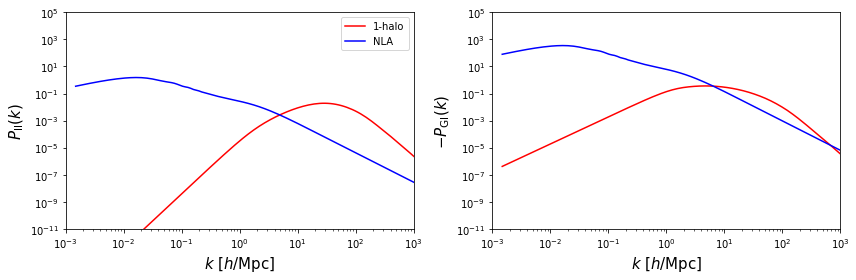

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(k_arr_over_h, pk_II_1h.eval(k_arr, 1., cosmo), label='1-halo', c='r')
ax[0].plot(k_arr_over_h, pk_II_NLA, label='NLA', c='b', ls='-')
ax[0].set_ylabel(r'$P_{\mathrm{II}}(k)$', fontsize=15)
ax[0].set_xlabel(r'$k\,\,[h/{\rm Mpc}]$', fontsize=15)
ax[0].legend()

ax[1].plot(k_arr_over_h, -pk_GI_1h.eval(k_arr, 1., cosmo), label='1-halo', c='r')
ax[1].plot(k_arr_over_h, -pk_GI_NLA, label='NLA', c='b', ls='-')
ax[1].set_ylabel(r'$-P_{\mathrm{GI}}(k)$', fontsize=15)
ax[1].set_xlabel(r'$k\,\,[h/{\rm Mpc}]$', fontsize=15)

for a in ax:
    a.set_xlim([1e-3, 1e3])
    a.set_ylim([1e-11, 1e5])
    a.set_xscale('log')
    a.set_yscale('log')

fig.tight_layout()
plt.show()

Other contributions can also be considered, such as 2-halo terms and contributions from central galaxies. However, on small scales the satellite 1-halo term dominates while on large scales alignments follow the NLA model.

Now we can compute the angular power spectrum of the total GI and II contributions using a redshift distributions and the CCL tracers. As an example, we show a redshift distribution at low redshift, where the signal difference is most significant.

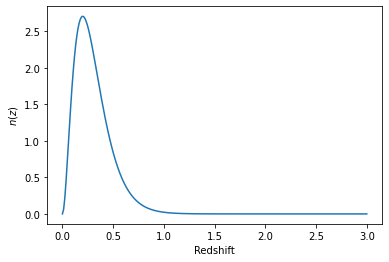

In [11]:
z_arr = np.linspace(0., 3., 256)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.1#0.0417*i_lim - 0.744
pz = 1./(2.*z0) * (z_arr / z0)**2. * np.exp(-z_arr/z0)

plt.plot(z_arr, pz)
plt.xlabel('Redshift')
plt.ylabel('$n(z)$')

bi1 = np.ones(len(z_arr)) # A_IA = 1 in the NLA model
# A tracer without shear and A_ia contribution. The alignment will be from the power spectrum.
ia_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz), has_shear=False, ia_bias = (z_arr,bi1), use_A_ia=False)
# A tracer without shear but with A_ia, to plot the NLA-only contribution for comparison.
ia_NLA_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz), has_shear=False, ia_bias = (z_arr,bi1), use_A_ia=True)
# A weak gravitational lensing tracer for the GI term.
wl_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz))

l_arr = np.geomspace(10, 10000).astype(int)

cl_GI_1h = ccl.angular_cl(cosmo, wl_tracer, ia_tracer, l_arr, p_of_k_a = pk_GI_1h)
cl_II_1h = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, l_arr, p_of_k_a = pk_II_1h)
cl_GI_NLA = ccl.angular_cl(cosmo, wl_tracer, ia_NLA_tracer, l_arr)
cl_II_NLA = ccl.angular_cl(cosmo, ia_NLA_tracer, ia_NLA_tracer, l_arr)
cl_GG = ccl.angular_cl(cosmo, wl_tracer, wl_tracer, l_arr)
cl_GI = cl_GI_1h + cl_GI_NLA
cl_II = cl_II_1h + cl_II_NLA

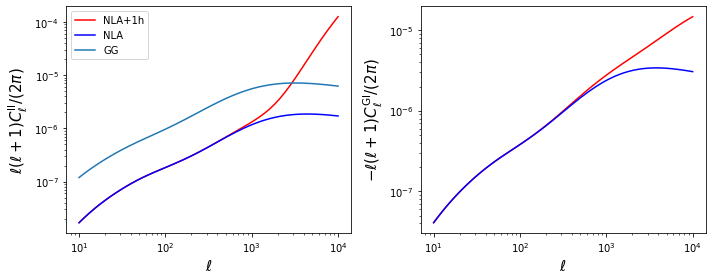

In [12]:
lfac = l_arr * (l_arr + 1) / (2 * np.pi)

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(l_arr, lfac * cl_II, label='NLA+1h', c='red')
ax[0].plot(l_arr, lfac * cl_II_NLA, label='NLA', c='blue')
ax[0].plot(l_arr, lfac * cl_GG, label='GG')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell^{\mathrm{II}}/(2\pi)$', fontsize=15)
ax[0].legend()

ax[1].plot(l_arr, -lfac * cl_GI, c='red')
ax[1].plot(l_arr, -lfac * cl_GI_NLA, c='blue')
ax[1].set_ylabel(r'$-\ell(\ell+1)C_\ell^{\mathrm{GI}}/(2\pi)$', fontsize=15)

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
#    a.set_ylim([1e-7, 1e-4])
    a.set_xlabel(r'$\ell$', fontsize=15)

fig.tight_layout()
plt.show()

# Windowed power spectra
We also show here how to generate an angular power spectrum that is determined by two window functions to treat double counting at intermediate scales, following what is done in Fortuna et al. 2021,
$$
P(k,a) = P_\mathrm{NLA}(k,a)\exp\left[-(k/k_\mathrm{2h})^2\right]+P_\mathrm{1h}^s(k,a)\left(1-\exp\left[-(k/k_\mathrm{1h})^2\right]\right)
$$
To incorporate this windowing, we need to generate arrays with values of $k$, $a$ and the relevant $P(k,a)$ and use them to create a new Pk2D object with these arrays.

In [13]:
pk_GI_windowed = np.empty((len(a_arr), len(k_arr)))
pk_II_windowed = np.empty((len(a_arr), len(k_arr)))
k1h = 4*cosmo['h'] #1/Mpc
k2h = 6*cosmo['h'] #1/Mpc

for i,a in enumerate(a_arr):
    pk_GI_NLA = -C1tilde * ccl.nonlin_matter_power(cosmo, k_arr, a)
    pk_GI_windowed[i,:] = pk_GI_1h.eval(k_arr, a, cosmo) * (1-np.exp(-(k_arr/k1h)**2)) + pk_GI_NLA * np.exp(-(k_arr/k2h)**2)
    pk_II_NLA = C1tilde**2 * ccl.nonlin_matter_power(cosmo, k_arr, a)
    pk_II_windowed[i,:] = pk_II_1h.eval(k_arr, a, cosmo) * (1-np.exp(-(k_arr/k1h)**2)) + pk_II_NLA * np.exp(-(k_arr/k2h)**2)

Now, we create the Pk2D objects and use them to calculate the angular correlation functions.

In [14]:
pk2d_GI_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), pk_arr=pk_GI_windowed, is_logp=False)
pk2d_II_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), pk_arr=pk_II_windowed, is_logp=False)
cl_GI_windowed = ccl.angular_cl(cosmo, wl_tracer, ia_tracer, l_arr, p_of_k_a = pk2d_GI_windowed)
cl_II_windowed = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, l_arr, p_of_k_a = pk2d_II_windowed)

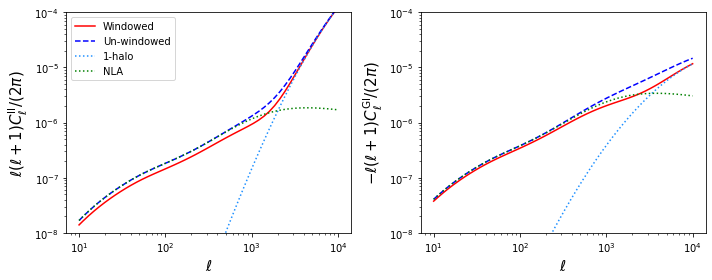

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(l_arr, lfac * cl_II_windowed, label='Windowed', c='red')
ax[0].plot(l_arr, lfac * cl_II, label='Un-windowed', c='blue', ls='--')
ax[0].plot(l_arr, lfac * cl_II_1h, label='1-halo', c='dodgerblue', ls='dotted')
ax[0].plot(l_arr, lfac * cl_II_NLA, label='NLA', c='green', ls='dotted')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell^{\mathrm{II}}/(2\pi)$', fontsize=15)
ax[0].legend()

ax[1].plot(l_arr, -lfac * cl_GI_windowed, c='red')
ax[1].plot(l_arr, -lfac * cl_GI, label='Un-windowed', c='blue', ls='--')
ax[1].plot(l_arr, -lfac * cl_GI_1h, label='1-halo', c='dodgerblue', ls='dotted')
ax[1].plot(l_arr, -lfac * cl_GI_NLA, label='NLA', c='green', ls='dotted')
ax[1].set_ylabel(r'$-\ell(\ell+1)C_\ell^{\mathrm{GI}}/(2\pi)$', fontsize=15)

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_ylim([1e-8, 1e-4])
    a.set_xlabel(r'$\ell$', fontsize=15)

fig.tight_layout()
plt.show()